## **Identificación De Especies de Mosquitos - Data Science**

Carol Arévalo, Stefano Aragoni, Luis Santos, Diego Perdomo

### *Modelo*

El Ministerio de Salud y Asistencia Social (MSPAS) ha informado que Guatemala ha experimentado un aumento significativo en el número de casos de dengue en 2023, con más de 10,000 casos confirmados y 21 muertes hasta el 12 de agosto. El MSPAS ha declarado una alerta epidemiológica en todo el país para combatir la propagación del dengue (Gobierno De Guatemala, 2023).  


Con esto en mente, el presente proyecto busca utilizar técnicas de procesamiento de imágenes y aprendizaje automático para identificar la especie de mosquito Aedes aegypti a partir de imágenes, con el fin de apoyar los esfuerzos de prevención del dengue en Guatemala.

#### Librerías

Como primer paso, se importan las librerías necesarias para el desarrollo del proyecto.

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
from skimage import color
from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

#### Cargas las imagenes

In [2]:
data = pd.read_csv('phase2_train_v0.csv')

#### Preprocesamiento

##### Analizar la Distribución de Clases


In [3]:
class_distribution = data['class_label'].value_counts()
print(class_distribution)

albopictus            4612
culex                 4563
culiseta               622
japonicus/koreicus     429
anopheles               84
aegypti                 47
Name: class_label, dtype: int64


#### Estandarización de Imágenes

In [4]:
input_folder = 'final'
output_folder = 'procesadas'
target_width = 100
target_height = 100

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


    for index, row in tqdm(data.iterrows(), total=data.shape[0]):
        filename = row.img_fName
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path)
        img = img.crop((row.bbx_xtl, row.bbx_ytl, row.bbx_xbr, row.bbx_ybr))
        img = img.resize((target_width, target_height), Image.LANCZOS)
        
        img = img.convert("L")
        
        img = np.array(img) / 255.0
        output_path = os.path.join(output_folder, filename)
        img = Image.fromarray((img * 255).astype(np.uint8))
        img.save(output_path)

else:
    print('Las imágenes ya están procesadas')

Las imágenes ya están procesadas


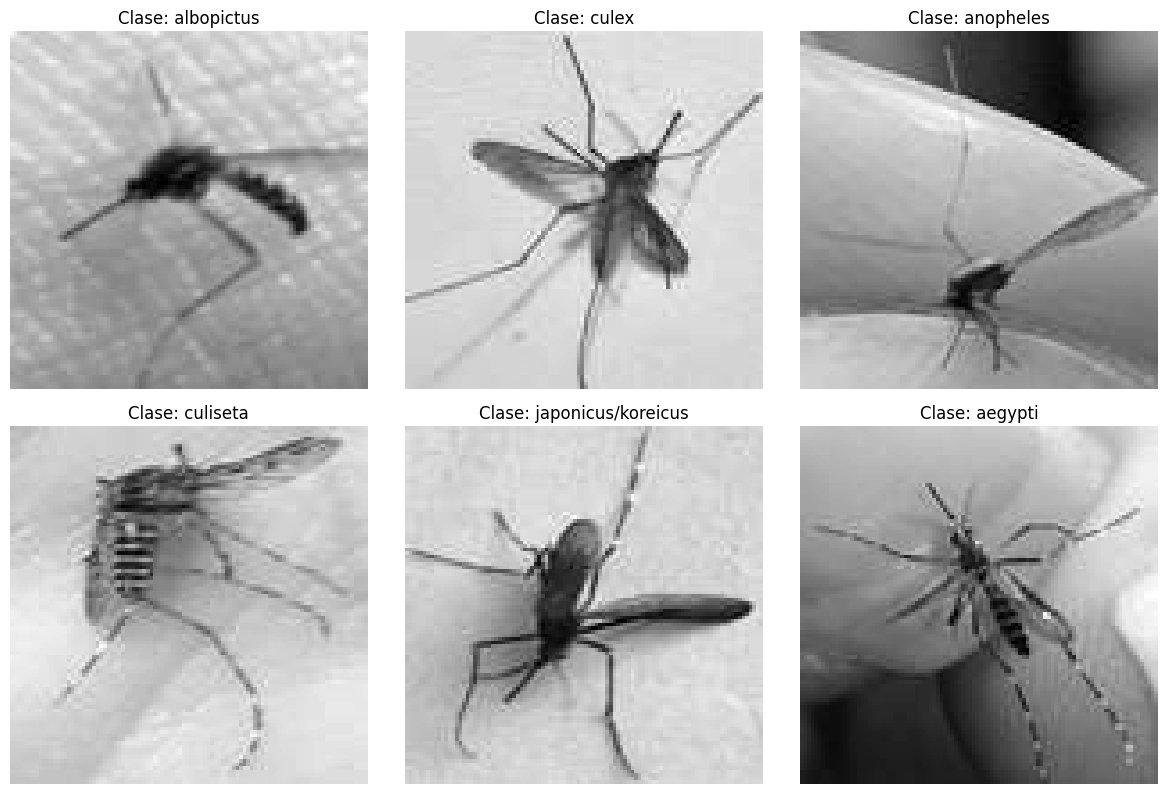

In [5]:
unique_classes = data['class_label'].unique()
num_rows = len(unique_classes) // 3 + 1
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, class_label in enumerate(unique_classes):
    class_data = data[data['class_label'] == class_label]
    first_image_name = class_data.iloc[0]['img_fName']
    image_path = os.path.join(output_folder, first_image_name)
    img = Image.open(image_path)
    
    row = i // num_cols
    col = i % num_cols
    
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(f'Clase: {class_label}')
    axes[row, col].axis('off')

for i in range(len(unique_classes), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

In [6]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

max_images = data['class_label'].value_counts().max()
data_balanced = pd.DataFrame(columns=['img_fName', 'class_label'])
data_balanced = pd.concat([data_balanced, data], ignore_index=True)
unique = data['class_label'].unique()

for class_label in tqdm(unique):
    class_count = sum(data['class_label'] == class_label)
    
    if class_count < max_images:
        num_new_images = max_images - class_count
        class_images = data[data['class_label'] == class_label]['img_fName']
        
        for i, original_image_name in enumerate(class_images):
            img = load_img(os.path.join(output_folder, original_image_name), color_mode='grayscale')
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                i += 1
                if i > num_new_images:
                    break
                
                new_img = array_to_img(batch[0], scale=False)
                new_image_name = f'new_image_{original_image_name.split(".")[0]}_{i}.jpeg'
                new_img.save(os.path.join(output_folder, new_image_name))
                
                new_data = pd.DataFrame({
                    'img_fName': [new_image_name],
                    'class_label': [class_label]
                })
                data_balanced = pd.concat([data_balanced, new_data], ignore_index=True)
                
            if i >= num_new_images:
                break

100%|██████████| 6/6 [00:16<00:00,  2.77s/it]


In [7]:
data_balanced = shuffle(data_balanced)
print(data_balanced['class_label'].value_counts())

data_balanced.to_csv('data_balanced.csv', index=False)

culex                 4612
aegypti               4612
japonicus/koreicus    4612
anopheles             4612
albopictus            4612
culiseta              4612
Name: class_label, dtype: int64


In [8]:
# Extracción de características HOG y preparación del dataset
features = []
labels = []

for index, row in tqdm(data_balanced.iterrows(), total=data_balanced.shape[0]):
    img_path = os.path.join(output_folder, row.img_fName)
    image = Image.open(img_path)
    
    # Extracción de características HOG
    feature = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    
    features.append(feature)
    labels.append(row.class_label)

100%|██████████| 27672/27672 [00:43<00:00, 633.04it/s]


In [9]:
# Conversión de listas a arrays
features = np.array(features)
labels = np.array(labels)

In [10]:
# Codificación de etiquetas
le = LabelEncoder()
labels_enc = le.fit_transform(labels)

In [11]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, labels_enc, test_size=0.2, random_state=42)

#### Definición y entrenamiento del modelo SVM

In [12]:
clf = svm.SVC(kernel='linear', probability=True, verbose=True)
clf.fit(X_train, y_train)

[LibSVM]...........*.......*
optimization finished, #iter = 18307
obj = -45.887850, rho = -5.372534
nSV = 917, nBSV = 0
Total nSV = 917
...........*.......*
optimization finished, #iter = 18505
obj = -47.839137, rho = -4.991840
nSV = 936, nBSV = 0
Total nSV = 936
..........*........*
optimization finished, #iter = 18031
obj = -41.427919, rho = -6.642630
nSV = 918, nBSV = 0
Total nSV = 918
.........*.......*
optimization finished, #iter = 16481
obj = -40.095482, rho = -5.482077
nSV = 914, nBSV = 0
Total nSV = 914
...........*.......*
optimization finished, #iter = 18786
obj = -51.548357, rho = -4.827348
nSV = 940, nBSV = 0
Total nSV = 940
..............*...........*
optimization finished, #iter = 25067
obj = -65.139903, rho = 6.165308
nSV = 1030, nBSV = 1
...*..*
optimization finished, #iter = 5303
obj = -9.183621, rho = -6.789238
nSV = 580, nBSV = 0
Total nSV = 580
...*.*
optimization finished, #iter = 4962
obj = -9.173899, rho = -4.561355
nSV = 569, nBSV = 0
Total nSV = 569
..*...*
op

SVC(kernel='linear', probability=True, verbose=True)

#### Resultados del Modelo

In [13]:
# Evaluación del modelo
y_pred_train = clf.predict(X_train)
print("Accuracy on Train data: ", accuracy_score(y_train, y_pred_train))

y_pred_test = clf.predict(X_test)
print("Accuracy on Test data: ", accuracy_score(y_test, y_pred_test))

print("\nClassification Report:\n", classification_report(y_test, y_pred_test, target_names=le.classes_))

Accuracy on Train data:  0.9412296155757329
Accuracy on Test data:  0.758446251129178

Classification Report:
                     precision    recall  f1-score   support

           aegypti       0.88      0.95      0.91       920
        albopictus       0.51      0.56      0.53       906
         anopheles       0.95      0.97      0.96       908
             culex       0.50      0.48      0.49       922
          culiseta       0.87      0.79      0.83       965
japonicus/koreicus       0.87      0.80      0.83       914

          accuracy                           0.76      5535
         macro avg       0.76      0.76      0.76      5535
      weighted avg       0.76      0.76      0.76      5535



#### Guardar el modelo

In [14]:
from joblib import dump
dump({"model": clf, "labelencoder": le}, "best_model2.joblib")


['best_model2.joblib']

#### Validacion con imagen 

In [15]:
# Función de predicción para una nueva imagen
def predict_mosquito_type_svm(clf, img_path):
    img = Image.open(img_path)
    feature = hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)

    prediction = clf.predict([feature])
    predicted_label = le.inverse_transform(prediction)[0]

    # Obteniendo el porcentaje de confianza
    prediction_proba = clf.predict_proba([feature])
    confidence = prediction_proba[0][prediction[0]] * 100  # Convertir la probabilidad a porcentaje
    
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {predicted_label} (Confidence: {confidence:.2f}%)")
    plt.axis("off")
    plt.show()

    return predicted_label

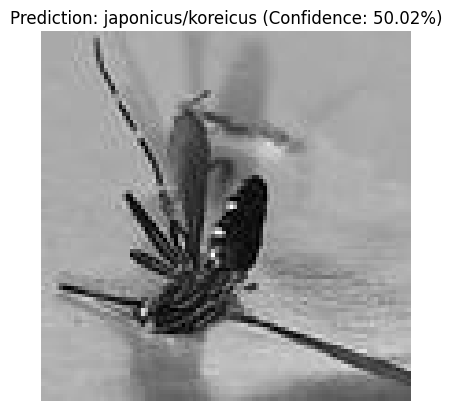

'japonicus/koreicus'

In [16]:
# Probando con una nueva imagen
predict_mosquito_type_svm(clf, "prueba.jpeg")